In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as tick
import seaborn as sns
import datetime
%matplotlib inline

def get_data(url):
    response = get(endpoint, timeout=10)
    
    if response.status_code >= 400:
        raise RuntimeError(f'Request failed: { response.text }')
        
    return response.json()


def today_anno(data):
    
    today = data[data["date_real"]==data["date_real"].max()]
    
    if today["date_real"].iloc[0].weekday() in [0,1,2,3,6]:
        return today, f'{int(today["vaxes"].iloc[0]):,}' + " vaccinations"
        
    elif today["date_real"].iloc[0].weekday() in [4,5]:
        return today, f'{int(today["vaxes"].iloc[0]):,}' + " vaccinations\n(excl Scotland and Wales)"

def y_fmt(tick_val,pos):
    """ Function to format y axis ticks as e.g. 100,000 = 100k
         
         Args:
            tick_val: Tick value
            pos: position of tick

         Returns:
            String for tick value
    """
    
    if tick_val > 1000000:
        val = int(tick_val/1000000)
        return '{:d}M'.format(val)
    
    elif tick_val > 1000:
        val = int(tick_val/1000)
        return '{:d}k'.format(val) 
    
    else: 
        return int(tick_val)

In [31]:
endpoint = (
'https://api.coronavirus.data.gov.uk/v1/data?'
'filters=areaType=overview&'
'structure={"date":"date","newPeopleVaccinatedFirstDoseByPublishDate":"newPeopleVaccinatedFirstDoseByPublishDate","newPeopleVaccinatedSecondDoseByPublishDate":"newPeopleVaccinatedSecondDoseByPublishDate"}'
)
data = get_data(endpoint)
df=pd.json_normalize(data,"data")

#Change date from index to datetime variable and sum 1st and 2nd doses for overall doses per day 
by_date = df.groupby("date").sum().reset_index()
by_date["date_real"] = pd.to_datetime(by_date["date"])
by_date["vaxes"] = by_date["newPeopleVaccinatedFirstDoseByPublishDate"] + by_date["newPeopleVaccinatedSecondDoseByPublishDate"]

#calculate 7 day rolling average
by_date["7day_avg"] = by_date["vaxes"].rolling(7).mean()
by_date["7day_index"] = by_date.index - 1

#calculate number over past 7 days
past_7days = by_date["vaxes"].iloc[-7:].sum()

#Get latest day only
today = by_date[by_date["date_real"]==by_date["date_real"].max()]


In [40]:
#Create numpy array of all dates from 11/01/21 to 07/02/21
start_date = datetime.date(2021, 1 , 11)
end_date = datetime.date(2021, 2 , 7)
end_datetime = datetime.datetime(2021, 2 , 7,0,0,0) #Keep a datetime of the end date so annoations can be plotted precisely 
number_of_days = (end_date - start_date).days + 1
date_list = np.asarray([(start_date + datetime.timedelta(days = day)) for day in range(number_of_days)])
x_labels = np.asarray([(start_date + datetime.timedelta(days = day)).strftime('%d/%m') for day in range(number_of_days)])


#Number of vaccinations per day needed for 2m/weeek, 3m/week and 4m/week
target_2mpd = float(2000000/7)
target_3mpd = float(3000000/7)
target_4mpd = float(4000000/7)
target_2m = np.asarray([target_2mpd for day in range(number_of_days)])
target_3m = np.asarray([target_3mpd for day in range(number_of_days)])
target_4m = np.asarray([target_4mpd for day in range(number_of_days)])

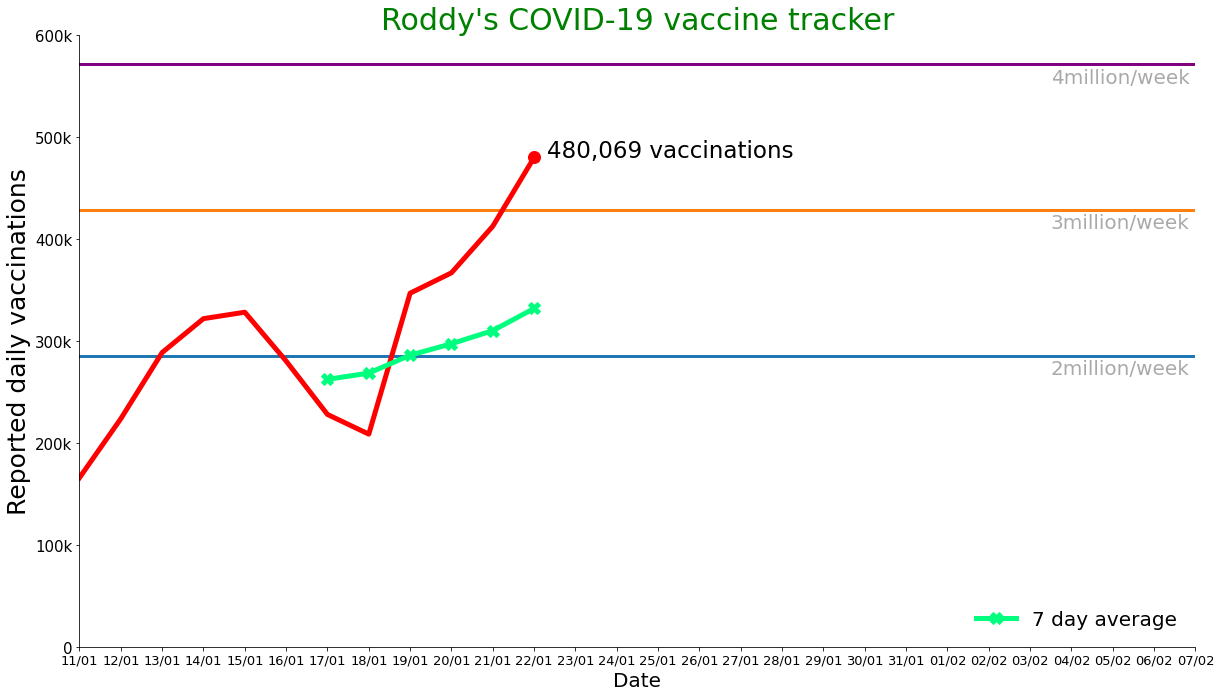

In [41]:
#Plot vaccinations per day and reference lines for 2m, 3m and 4m vaccinations per week 
fig, ax = plt.subplots(1,1,figsize=[20,11.25],facecolor="white")
ax.set_facecolor("white")

ax.plot(date_list, target_2m,label='_nolegend_',lw=3)
ax.text(end_datetime-datetime.timedelta(days = 3.5),target_2mpd-18000,"2million/week", fontdict={'size':20, 'color':'darkgrey'})

ax.plot(date_list, target_3m,label='_nolegend_',lw=3)
ax.text(end_datetime-datetime.timedelta(days = 3.5),target_3mpd-18000,"3million/week", fontdict={'size':20, 'color':'darkgrey'})

ax.plot(date_list, target_4m, c='purple',label='_nolegend_',lw=3)
ax.text(end_datetime-datetime.timedelta(days = 3.5),target_4mpd-18000,"4million/week", fontdict={'size':20, 'color':'darkgrey'})

ax.plot(by_date["date_real"],by_date["vaxes"],c="r", lw=5,label='_nolegend_')
ax.plot(today["date_real"],today["vaxes"],"ro", ms=12,label='_nolegend_')
ax.text(today["date_real"]+datetime.timedelta(days = 0.3),today["vaxes"],f'{int(today["vaxes"].iloc[0]):,}' + " vaccinations", fontdict={'size':23})

ax.plot(by_date["date_real"],by_date["7day_avg"],c="springgreen",lw=5, marker='X',ms=12)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.set_xlim(start_date, end_date)
ax.set_xticks(date_list)
ax.set_xticklabels(x_labels)

ax.set_ylim([0,600000])
ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))

ax.tick_params(axis='y',labelsize=15)
ax.tick_params(axis='x',labelsize=13)

ax.legend(["7 day average"],loc='lower right',fontsize=20,frameon=False)

plt.title("Roddy's COVID-19 vaccine tracker",
        fontsize=30, color='g' )
plt.xlabel('Date',fontsize=20)
plt.ylabel('Reported daily vaccinations',fontsize=25)

sns.despine(top=True, right=True)
